In [1]:
# importing packages
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix
# download the stopword from nltk package
nltk.download('stopwords')

nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

!python -m spacy download en_core_web_sm -q
nlp = spacy.load("en_core_web_sm")
# Visulalize Data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kanag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


<div style="text-align: center;"> <h1>Data Preprocessing</h1> </div>

In [2]:
#Loading dataset into dataframe
pd.set_option('display.max_columns',5)
# load dataset into dataframe
complaints_df = pd.read_csv('data/complaints.zip',compression='zip',index_col=0)
# complaints_df = pd.read_csv('complaints.csv', index_col=0)
complaints_df.columns = ['product','narrative']
# view first 5 rows
complaints_df.head()

product                                          narrative
0       credit_card  purchase order day shipping amount receive pro...
1       credit_card  forwarded message date tue subject please inve...
2    retail_banking  forwarded message cc sent friday pdt subject f...
3  credit_reporting  payment history missing credit report speciali...
4  credit_reporting  payment history missing credit report made mis...

In [50]:
complaints_df.shape

(162421, 2)

>The Dataset contains 162,421 rows and three columns.

In [51]:
complaints_df.groupby('product').describe()

narrative         \
                        count unique   
product                                
credit_card             15566  15024   
credit_reporting        91172  56303   
debt_collection         23148  21117   
mortgages_and_loans     18990  18759   
retail_banking          13535  13473   

                                                                             
                                                                   top freq  
product                                                                      
credit_card          see multiple day late mark clear violation rig...  130  
credit_reporting     victim identity notified collection creditor s...  739  
debt_collection      disputed account reached many time failed acco...  167  
mortgages_and_loans  see multiple day late mark clear violation rig...   83  
retail_banking       paypal negative transfer loading transaction d...    8

<div style="text-align: left;"> <h2>Handling Null values</h2> </div>

In [52]:
complaints_df.isna().sum()

product       0
narrative    10
dtype: int64

In [53]:
complaints_df = complaints_df.dropna(how='any',axis=0)

In [54]:
complaints_df.isna().sum()

product      0
narrative    0
dtype: int64

<div style="text-align: left;"> <h2>Remove Duplicate Data</h2> </div>

In [55]:
complaints_df.groupby(complaints_df.duplicated(), as_index=False).size()

index    size
0  False  124676
1   True   37735

In [57]:
data_duplicated = complaints_df[complaints_df.duplicated(subset='narrative', keep=False)]
data_duplicated['frequency'] = data_duplicated.groupby('narrative')['narrative'].transform('count')
data_duplicated.drop_duplicates(subset='narrative', keep='first', inplace=True)
data_duplicated.sort_values(by='frequency', ascending=False)

product                                          narrative  \
28837  credit_reporting  victim identity notified collection creditor s...   
3217   credit_reporting  account added created unbeknownst notice conce...   
521    credit_reporting  filed dispute regard incorrect item credit rep...   
28124  credit_reporting  victim identity theft due corona virus pandemi...   
27356  credit_reporting                              victim identity theft   
...                 ...                                                ...   
76542  credit_reporting  sent letter certified inaccuracy credit report...   
76540  credit_reporting  sent letter certified day ago still notified u...   
76537  credit_reporting  sent letter certified day ago one reached righ...   
76534  credit_reporting  sent letter certified day ago didnt get notifi...   
80715  credit_reporting  charged late fee month however bill sent addre...   

       frequency  
28837        739  
3217         415  
521          338  
28124        306  
27356        271  
...          ...  
76542          2  
76540          2  
76537          2  
76534          2  
80715          2  

[12281 rows x 3 columns]

In [59]:
# dropping duplicate values
complaints_df.drop_duplicates(subset='narrative', keep='first', inplace=True)
complaints_df.groupby(complaints_df.duplicated(), as_index=False).size()

index    size
0  False  124472

<div style="text-align: left;"> <h2>Normalizaing the text</h2> </div>

**Apply lowercasing:** Lowercasing text is a standard preprocessing in NLP projects. In NLP, a 'token' is a sequence of characters that we treat as a single unit. Different cases of the same word are treated as distinct tokens, which increases the data size. The lowercase text helps reduce the vocabulary size. Also, the machine learning models perform better when the text is uniform.

In [60]:
# convert text into lower case
complaints_df['narrative']=complaints_df['narrative'].where(pd.notna(complaints_df['narrative']),None)
complaints_df['narrative']=complaints_df['narrative'].str.lower()
display(complaints_df)

product                                          narrative
0               credit_card  purchase order day shipping amount receive pro...
1               credit_card  forwarded message date tue subject please inve...
2            retail_banking  forwarded message cc sent friday pdt subject f...
3          credit_reporting  payment history missing credit report speciali...
4          credit_reporting  payment history missing credit report made mis...
...                     ...                                                ...
162411       retail_banking  zelle suspended account without cause banking ...
162412      debt_collection  zero contact made debt supposedly resolved fou...
162413  mortgages_and_loans  zillow home loan nmls nmls actual quote provid...
162414      debt_collection  zuntafi sent notice willing settle defaulted s...
162415      debt_collection                                               name

[124472 rows x 2 columns]

**Remove Stopwords:** In the bank customer complaint classification project, we will be tagging text to product type. Here, stop words(e.g., 'and,' 'the,' 'is,' etc.) don't carry significant meaning, and it is safe to remove them from the data. This step not only helps reduce the data size and increase computational efficiency but also has a profound impact on the model's performance. By removing stop words, we can simplify the model and reduce noise, leading to more accurate and reliable results.

**Remove Punctuations:** Punctuations are noise for this project and don't provide any value. Removing punctuation from the text is standard processing in the NLP project. It ensures that words are correctly identified and separated.

In [61]:
# get english stopwords
stop_words=set(stopwords.words('english'))

# create function to remove stop words and punctuation
def remove_stop_words_and_punctuation(text):
    words = text.split()
    filtered_words = [re.sub(r'[^\w\s]','',word) for word in words if word not in stop_words]
    return " ".join(filtered_words)

# apply remove stop word function on narrative column
complaints_df['narrative']=complaints_df['narrative'].apply(remove_stop_words_and_punctuation)
complaints_df.head()

product                                          narrative
0       credit_card  purchase order day shipping amount receive pro...
1       credit_card  forwarded message date tue subject please inve...
2    retail_banking  forwarded message cc sent friday pdt subject f...
3  credit_reporting  payment history missing credit report speciali...
4  credit_reporting  payment history missing credit report made mis...

**Lemmatization:**

In [104]:
# creating funtion for lemmatization
def lemmatize_text(texts):
    docs = nlp.pipe(texts, batch_size=100)
    return [' '.join([token.lemma_ for token in doc]) for doc in tqdm(docs, total=len(texts))]
  
    
complaints_df['narrative_clean'] = lemmatize_text(complaints_df['narrative'].tolist())
complaints_df.head()

100%|█████████████████████████████████████████████████████████████████████████| 124472/124472 [11:45<00:00, 176.38it/s]


product                                          narrative  ...  \
0       credit_card  purchase order day shipping amount receive pro...  ...   
1       credit_card  forwarded message date tue subject please inve...  ...   
2    retail_banking  forwarded message cc sent friday pdt subject f...  ...   
3  credit_reporting  payment history missing credit report speciali...  ...   
4  credit_reporting  payment history missing credit report made mis...  ...   

  narrative_length                                    narrative_clean  
0              230  purchase order day shipping amount receive pro...  
1              132  forward message date tue subject please invest...  
2              173  forward message cc send friday pdt subject fin...  
3              131  payment history miss credit report specialized...  
4              123  payment history miss credit report make mistak...  

[5 rows x 6 columns]

<div style="text-align: left;"> <h2>Feature Engineering</h2> </div>

In [105]:
# creating few attribute
complaints_df['product_num'] = complaints_df["product"].replace({
    "credit_card": "1",
    "retail_banking": "2",
    "credit_reporting": "3",
    "mortgages_and_loans": "4",
    "debt_collection": "5"
}, regex=False)
complaints_df['narrative_length'] = complaints_df['narrative_clean'].apply(lambda x: len(x.split(' ')))

complaints_df.sort_values(by='narrative_length', ascending=False).head()

product  \
119476  mortgages_and_loans   
7272       credit_reporting   
137348  mortgages_and_loans   
9773            credit_card   
12718   mortgages_and_loans   

                                                narrative  ...  \
119476  please refer full detail written within page p...  ...   
7272    public service staff federal trade commission ...  ...   
137348  complaint involves est mile time purchase incl...  ...   
9773    brink money netspend account application suppo...  ...   
12718   complaint herein given loan borrower hereinaft...  ...   

       narrative_length                                    narrative_clean  
119476             2702  please refer full detail write within page pdf...  
7272               2568  public service staff federal trade commission ...  
137348             2538  complaint involve est mile time purchase inclu...  
9773               2431  brink money netspend account application suppo...  
12718              2342  complaint herein give loan borrower hereinafte...  

[5 rows x 6 columns]

<div style="text-align: center;"> <h1>Exploratory Data Analysis (EDA)</h1> </div>

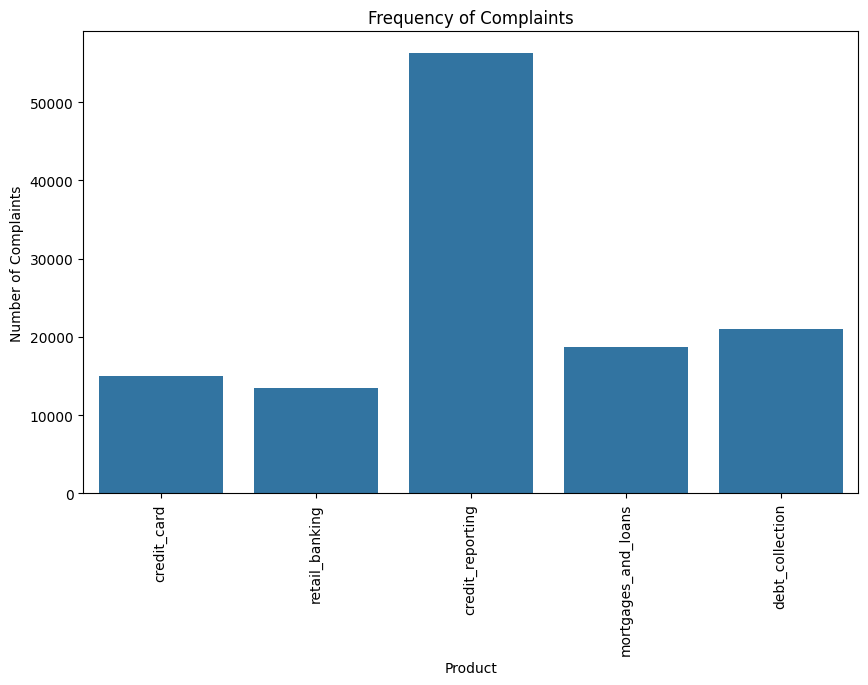

In [142]:
# creating bar chart
plt.figure(figsize=(10,6))
sns.countplot(x= complaints_df['product'])
plt.title("Frequency of Complaints")
plt.xticks(rotation = 90)
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.savefig('Frequency_of_Complaints_bar_chart.png', bbox_inches='tight')
plt.show()

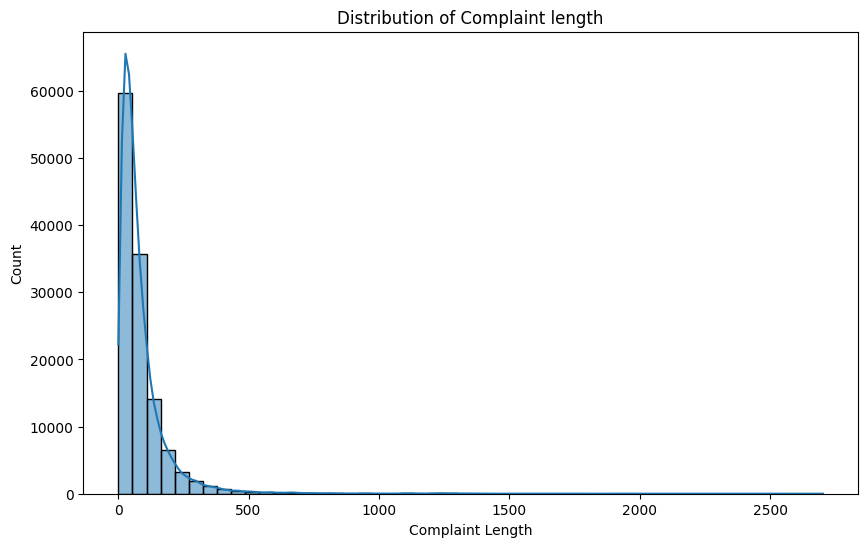

In [143]:
# creating histogram
plt.figure(figsize=(10,6))
sns.histplot(complaints_df['narrative_length'], kde = True, bins = 50)
plt.title("Distribution of Complaint length")
plt.xlabel('Complaint Length')
plt.savefig('Distribution_of_Complaint_length_hist_chart.png', bbox_inches='tight')
plt.show()

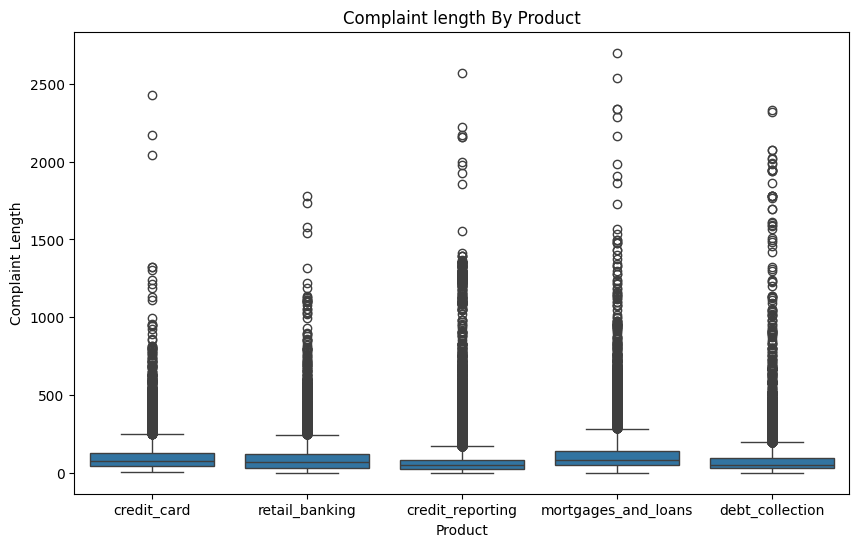

In [145]:
# creating box plot
plt.figure(figsize=(10,6))
sns.boxplot(x= complaints_df['product'],y=complaints_df['narrative_length'])
plt.title("Complaint length By Product")
plt.ylabel('Complaint Length')
plt.xlabel('Product')
plt.savefig('Complaint_lengths_By_Product_box_chart.png', bbox_inches='tight')
plt.show()

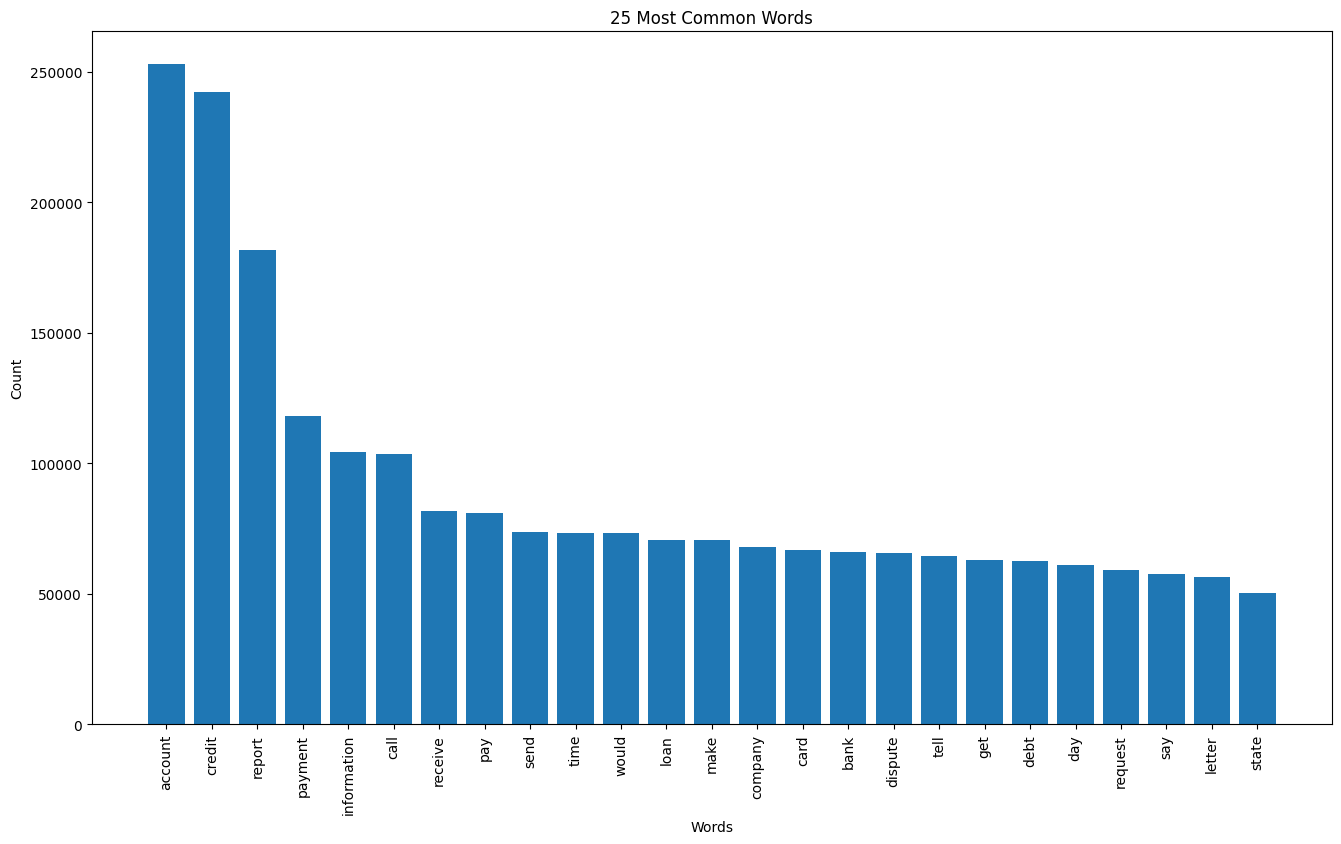

In [149]:
# Flatten the list of tokens and count the frequency of each token
tokens = complaints_df['narrative_clean'].apply(lambda x: x.split(' '))
all_words = [word for tokens in tokens for word in tokens]
word_freq = Counter(all_words)

# Get the 25 most common words
common_words = word_freq.most_common(25)

# Unzip the words and their counts
words, counts = zip(*common_words)

# Create a bar plot
plt.figure(figsize=(16,9))
plt.bar(words, counts)
plt.title('25 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

<Figure size 1000x600 with 0 Axes>

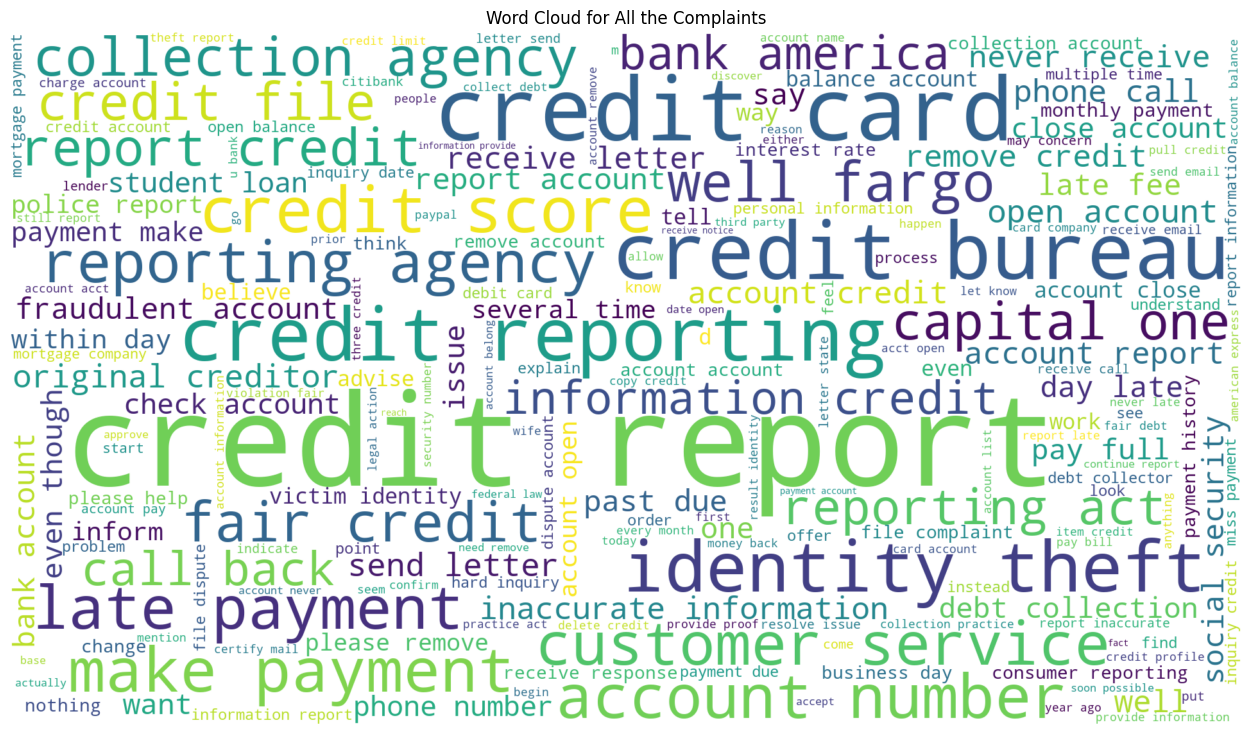

In [147]:
# creating word cloud
plt.figure(figsize=(10,6))
combine_text= ' '.join(complaints_df['narrative_clean'])
wordcloud_text= WordCloud(width=1920, height=1080, background_color='white').generate(combine_text)
plt.figure(figsize=(16,9))
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.title(f"Word Cloud for All the Complaints")
plt.axis('off')
plt.savefig('Word_Cloud_for_All_the_Complaints.png', bbox_inches='tight')
plt.show()

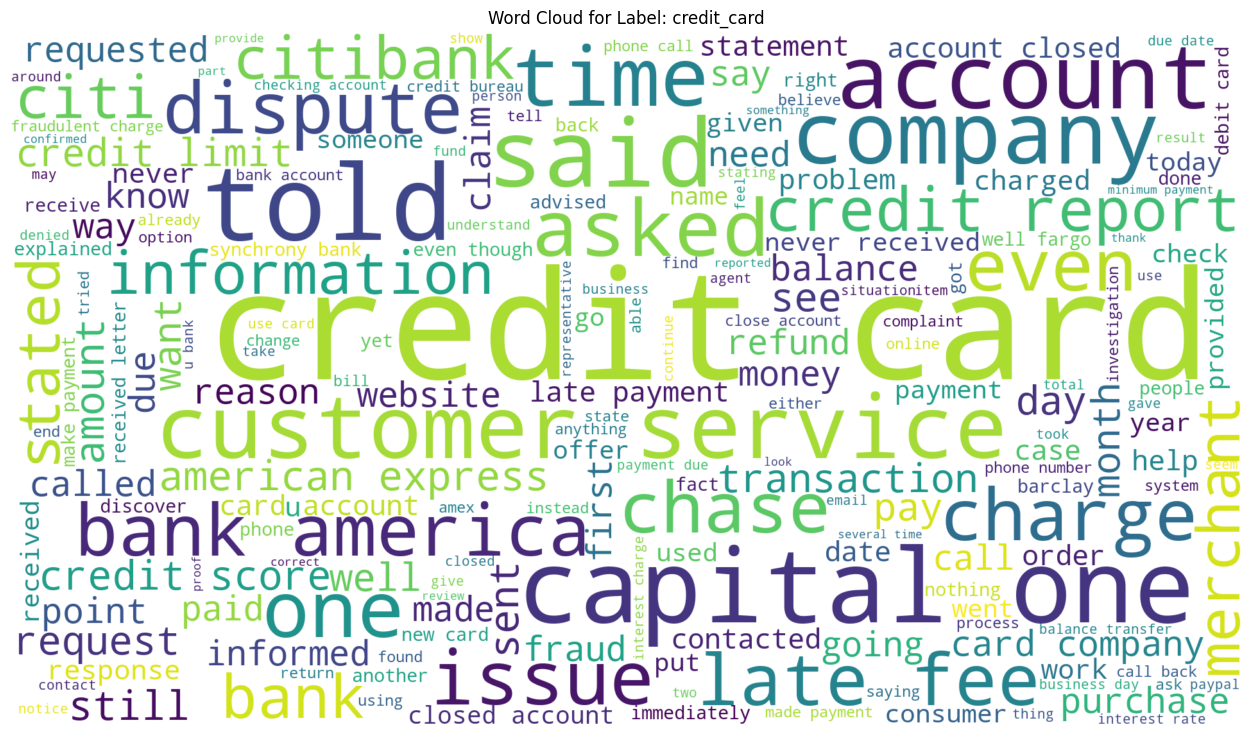

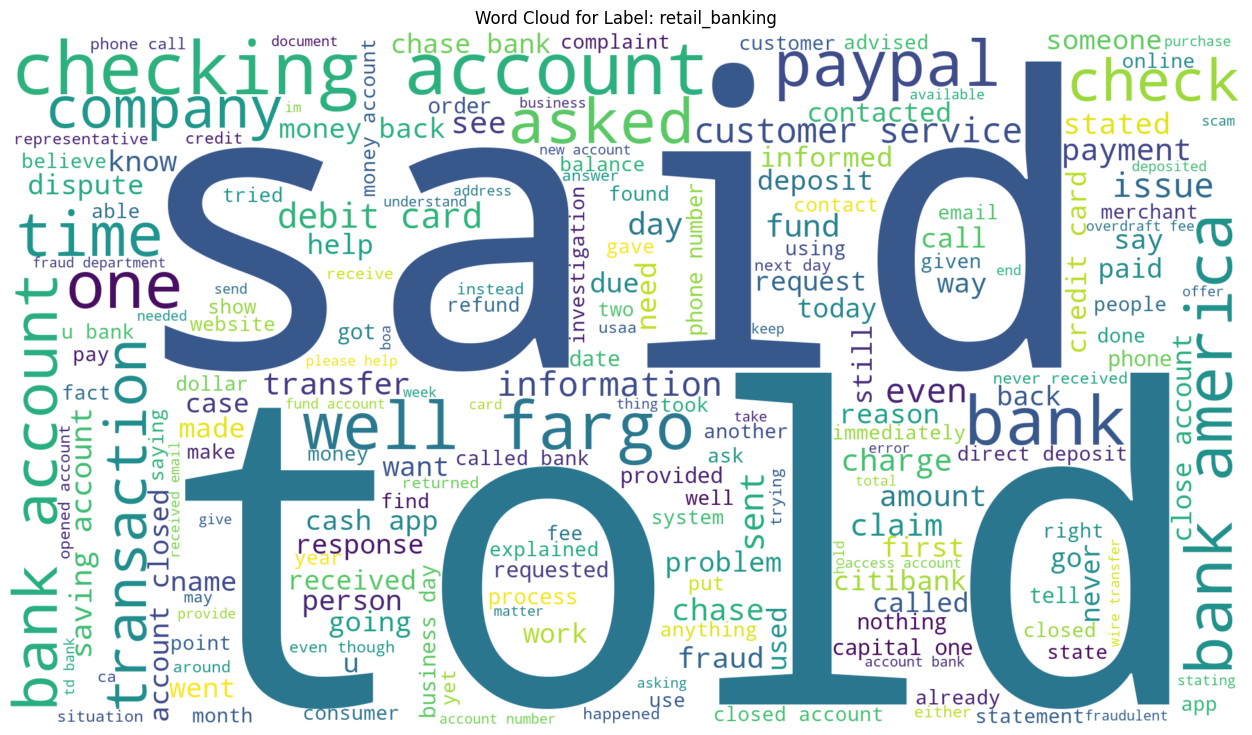

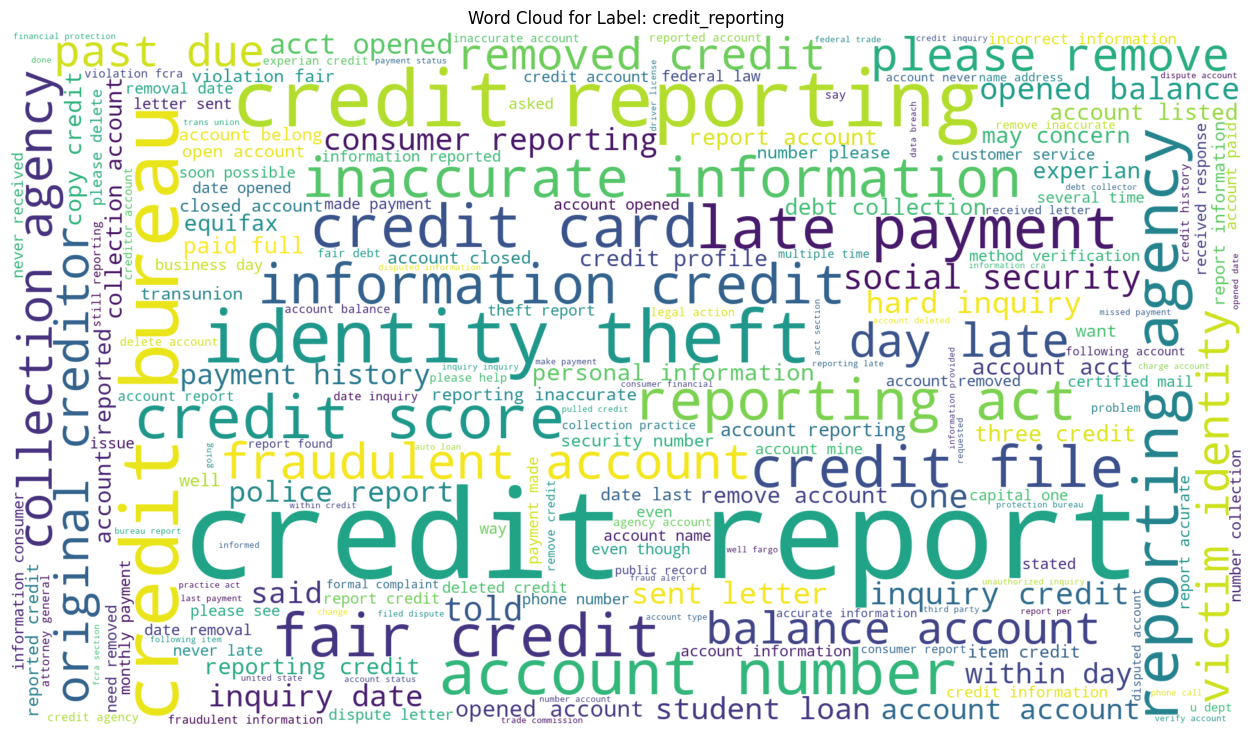

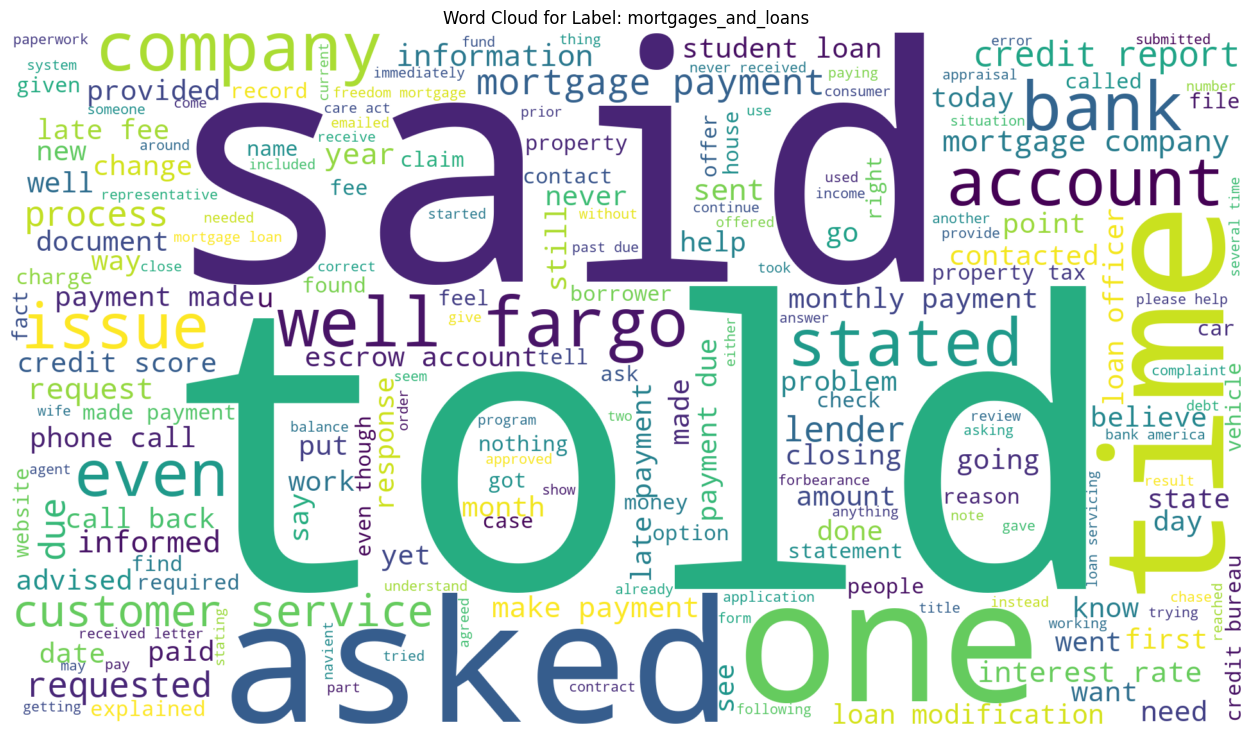

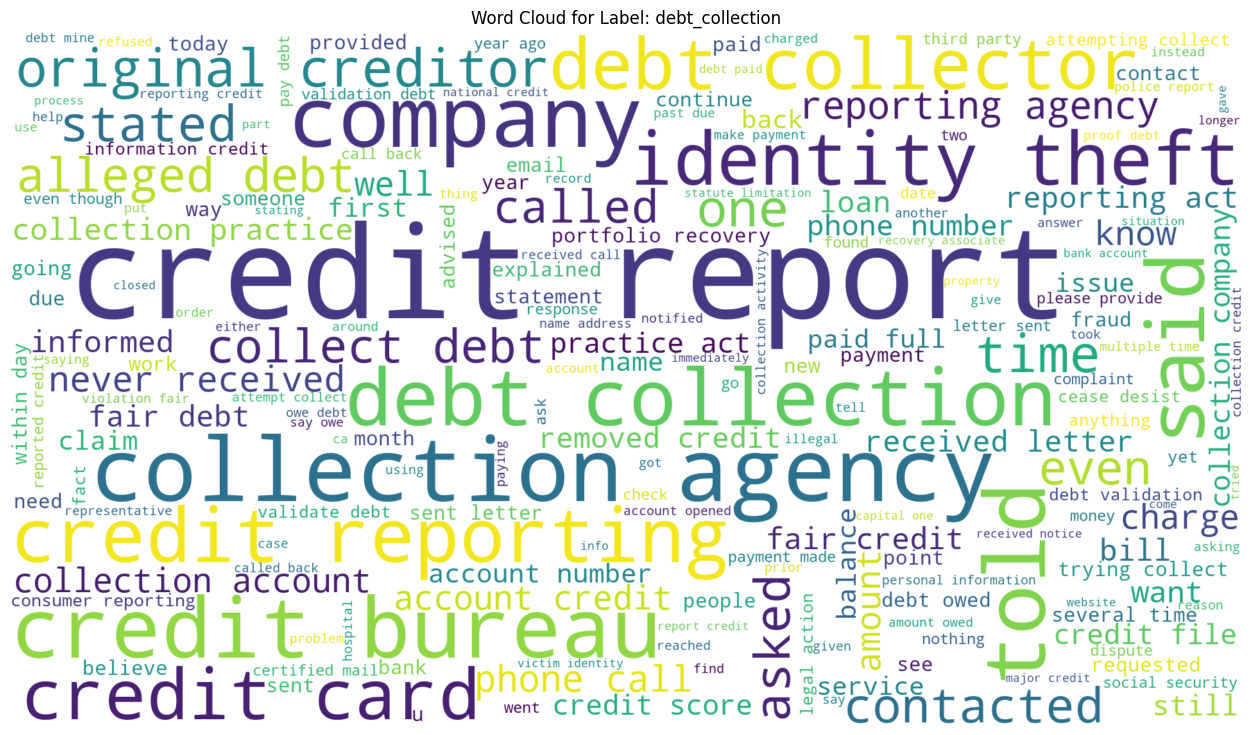

In [103]:
labels = complaints_df['product'].unique()
for label in labels:
    label_text = ' '.join(complaints_df[complaints_df['product'] == label]['narrative_clean'])
    wordcloud = WordCloud(width=1920, height=1080, background_color='white').generate(label_text)

    # Word cloud
    plt.figure(figsize=(16, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Label: {label}")
    plt.axis('off')
    plt.show()

<div style="text-align: center;"> <h1>Modeling</h1> </div>

<div style="text-align: left;"> <h2>Train Split Data</h2> </div>

In [110]:
X = complaints_df['narrative_clean']
y = complaints_df['product_num']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                  test_size=0.1,
                                                  random_state=42,
                                                  stratify=y_train_val)
print('Train Size : ', len(X_train))
print('Val Size   : ', len(X_val))
print('Test Size  : ', len(X_test))

Train Size :  89619
Val Size   :  9958
Test Size  :  24895


<div style="text-align: left;"> <h2>TfidfVectorizer</h2> </div>

**RandomForestClassifier**

In [123]:
pipe_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators = 400, oob_score= True,
                                                                  max_depth= 15, n_jobs = -1, random_state = 42))
pipe_rf.fit(X_train, y_train)
# Predict on the test set
y_pred_random_forest = pipe_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_random_forest))

Accuracy: 0.58
Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.14      0.25      2997
           2       0.88      0.27      0.42      2694
           3       0.52      0.99      0.69     11248
           4       0.88      0.46      0.61      3745
           5       0.98      0.07      0.12      4211

    accuracy                           0.58     24895
   macro avg       0.83      0.39      0.42     24895
weighted avg       0.74      0.58      0.50     24895



**MultinomialNB**

In [111]:
# Create a pipeline with a TF-IDF vectorizer and a Multinomial Naive Bayes classifier
model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
model1.fit(X_train, y_train)

# Predict on the test set
y_pred = model1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

cv_scores = cross_val_score(model1, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")

Accuracy: 0.77
Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.58      0.67      2997
           2       0.89      0.72      0.80      2694
           3       0.72      0.95      0.82     11248
           4       0.82      0.79      0.80      3745
           5       0.88      0.45      0.59      4211

    accuracy                           0.77     24895
   macro avg       0.82      0.70      0.74     24895
weighted avg       0.79      0.77      0.76     24895



<div style="text-align: left;"> <h2>Bag of Words</h2> </div>

**RandomForestClassifier**

In [132]:
pipe_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(n_estimators = 400, oob_score= True,
                                                                  max_depth= 15, n_jobs = -1, random_state = 42))
pipe_rf.fit(X_train, y_train)
# Predict on the test set
y_pred_random_forest = pipe_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_random_forest))

Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.12      0.20      2997
           2       0.88      0.27      0.41      2694
           3       0.52      1.00      0.68     11248
           4       0.91      0.43      0.59      3745
           5       0.97      0.06      0.12      4211

    accuracy                           0.57     24895
   macro avg       0.83      0.38      0.40     24895
weighted avg       0.73      0.57      0.49     24895



**MultinomialNB**

In [113]:
# Create a pipeline with a CountVectorizer and a Multinomial Naive Bayes classifier
model2 = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model
model2.fit(X_train, y_train)

# Predict on the test set
y_pred = model2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
cv_scores = cross_val_score(model2, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")

Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.78      0.73      2997
           2       0.80      0.88      0.84      2694
           3       0.89      0.82      0.85     11248
           4       0.76      0.89      0.82      3745
           5       0.76      0.71      0.73      4211

    accuracy                           0.81     24895
   macro avg       0.78      0.81      0.80     24895
weighted avg       0.82      0.81      0.81     24895



<div style="text-align: center;"> <h1>Hyperparameter Tuning</h1> </div>

In [150]:
# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'multinomialnb__alpha': uniform(0.1, 1.0),
}

model = make_pipeline(CountVectorizer(), MultinomialNB())

randomized_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

# Train the model with the best hyperparameters
randomized_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = randomized_search.best_estimator_

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy:.2f}")

# Print the best hyperparameters
print("Best Hyperparameters:", randomized_search.best_params_)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Best Model Accuracy: 0.86
Best Hyperparameters: {'countvectorizer__ngram_range': (1, 3), 'multinomialnb__alpha': 0.12058449429580245}
Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.81      0.78      2997
           2       0.84      0.88      0.86      2694
           3       0.91      0.89      0.90     11248
           4       0.83      0.90      0.86      3745
           5       0.84      0.76      0.80      4211

    accuracy                           0.86     24895
   macro avg       0.84      0.85      0.84     24895
weighted avg       0.86      0.86      0.86     24895



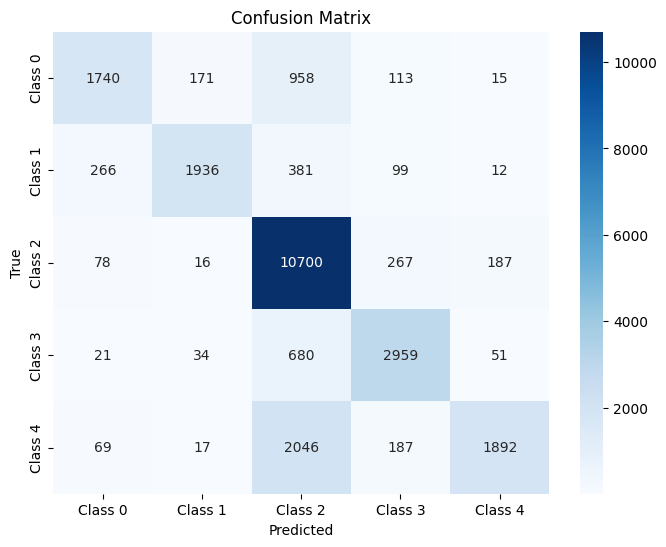

In [152]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()